In [1]:
from typing import List

import mlflow
import pandas as pd
import pytorch_lightning as pl
import torch
from mlflow import MlflowClient
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader, Dataset

/home/a/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Работаем над воспроизводимостью
# Make the code reproducible

torch.random.manual_seed(42)
import random
random.seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)

Seed set to 42


In [3]:
# Шаг 0. Создаем модель, с которой будем работать
# Step 0. Create the model, which we will be working with


# Шаг 0.1 Готовим класс датасета для лайтнинга
# Step 0.1 Preparing the Dataset class for Pytorch Lightning
from pytorch_lightning.core.module import LightningModule
from pytorch_lightning.trainer.trainer import Trainer


class TorchModelData(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        super().__init__()
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return self.X.shape[0]
    


# Шаг 0.2 Описываем модель
# Step 0.2 Describing the model
class LightningModel(pl.LightningModule):
    def __init__(
            self,
            in_features: int,
            layer_neurons: List[int],
            activation_function_class,
            opt=torch.optim.NAdam,
            lr=0.01
    ):
        super().__init__()
        self._in_features = in_features
        self._layer_neurons = layer_neurons
        self._lr = lr
        self._opt = opt

        layers = []
        for i in range(len(layer_neurons)):
            if i == 0:
                input_neurons = in_features
            else:
                input_neurons = layer_neurons[i-1]
            
            layers.append(torch.nn.Linear(input_neurons, layer_neurons[i]))
            if i != (len(layer_neurons) - 1):
                layers.append(activation_function_class())
        
        self._model = torch.nn.Sequential(*layers)

    def forward(self, x):
        if "cuda" in str(self.device) and not "cuda" in str(x.device):
            return self._model(x.cuda())
        else:
            return self._model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = torch.mean((y - preds)**2)
        self.log("train_mse", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = torch.mean((y - preds)**2)
        self.log("val_mse", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def configure_optimizers(self):
        opt = self._opt(self.parameters(), lr=self._lr)
        return opt
    

# Шаг 0.3 - создаем обратный вызов pytorch lightning, где будем фиксировать метрики по эпохам
# для MLFlow
# Step 0.3 - Make lightning callback to fix metrics by epoch

class MlflowMetricCallback(pl.Callback):
    def __init__(self, train_tensor, val_tensor, y_train, y_val):
        super().__init__()
        self._train_X = train_tensor
        self._val_X = val_tensor
        self._y_train = y_train.detach().cpu().numpy()
        self._y_val = y_val.detach().cpu().numpy()

    def on_train_epoch_end(self, trainer: Trainer, pl_module: LightningModule):
        preds_train = pl_module(self._train_X).detach().cpu().numpy()
        preds_val = pl_module(self._val_X).detach().cpu().numpy()

        epoch = trainer.current_epoch

        metrics = {
            "Train MAE": mean_absolute_error(self._y_train, preds_train),
            "Train R2": r2_score(self._y_train, preds_train),
            "Eval MAE": mean_absolute_error(self._y_val, preds_val),
            "Eval R2": r2_score(self._y_val, preds_val)
        }

        mlflow.log_metrics(metrics, step=epoch)

In [4]:
# Шаг 1. Загружаем данные
# Step 1. Load the data
data = pd.read_excel("Concrete_Data.xls")
data

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


In [5]:
target_name = "Concrete compressive strength(MPa, megapascals) "

In [6]:
# Шаг 2. Разбиваем данные на тренировку и валидацию
# Step 2. Split data into train and validation

X_train, X_val = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
y_train, y_val = X_train.pop(target_name), X_val.pop(target_name)

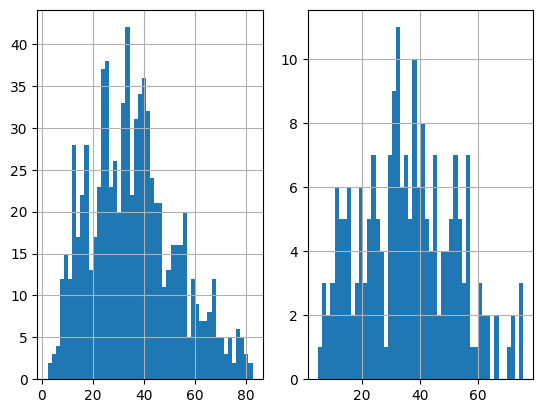

In [7]:
# Quick look at the target

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2)
y_train.hist(bins=50, ax=axs[0])
y_val.hist(bins=50, ax=axs[1])
plt.show()

In [8]:
# Шаг 3.0 Трансформируем данные
# Step 3.0 Transforming data

from sklearn.preprocessing import RobustScaler

sc = RobustScaler()
sc.fit(X_train)

train_tensor = sc.transform(X_train)
train_tensor = torch.as_tensor(train_tensor, dtype=torch.float32)

val_tensor = sc.transform(X_val)
val_tensor = torch.as_tensor(val_tensor, dtype=torch.float32)

y_train_tensor = torch.as_tensor(y_train.to_numpy(), dtype=torch.float32)
y_val_tensor = torch.as_tensor(y_val.to_numpy(), dtype=torch.float32)

In [9]:
# Шаг 4.0 Создаем загрузчики данных
# Step 4.0 Making dataloaders

train_ds = TorchModelData(train_tensor, y_train_tensor)
val_ds = TorchModelData(val_tensor, y_val_tensor)

train_dataloader = DataLoader(train_ds, batch_size=256)
val_dataloader = DataLoader(val_ds, batch_size=256)

In [10]:
# Шаг 5.0 Обучаем тестовую модель
# Step 5.0 Training a debug model

model = LightningModel(
    train_tensor.shape[1],
    [2, 1],
    torch.nn.ReLU
)

trainer = pl.Trainer(max_epochs=5, accelerator='cpu')
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params
--------------------------------------
0 | _model | Sequential | 21    
--------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 132.13it/s, v_num=94, val_mse=1.52e+3, train_mse=1.57e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 118.41it/s, v_num=94, val_mse=1.52e+3, train_mse=1.57e+3]


In [11]:
# Обучение прошло успешно, подключаем MLFLow
# Сначала запустим локальный сервер
# Для этого в терминале:
# mlflow server --host 127.0.0.1 --port 8080

# Training succeeded, now to connect to MLFlow
# To do that, start up the local server
# In terminal:
# mlflow server --host 127.0.0.1 --port 8080

# Далее, при включенном сервере:
# Next, when the server is running:

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

all_experiments = client.search_experiments()
print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/108242481070769059', creation_time=1715874255164, experiment_id='108242481070769059', last_update_time=1715874255164, lifecycle_stage='active', name='Concrete_Models', tags={'mlflow.note.content': 'Experiment on forecasting concrete strength',
 'project_name': 'concrete-strength'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1715596986922, experiment_id='0', last_update_time=1715596986922, lifecycle_stage='active', name='Default', tags={}>]


In [12]:
# Шаг 6.0 Создаем эксперимент, если его еще нет
# Step 6.0 Create the experiment, if it doesn't already exist

concrete_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'concrete-strength'"
)

if len(concrete_experiment) == 0:
    experiment_description = (
        "Experiment on forecasting concrete strength"
    )

    # Добавляем теги
    # Add tags
    experiment_tags = {
        "project_name": "concrete-strength",
        "mlflow.note.content": experiment_description,
    }

    # Создаем эксперимент, даем ему уникальное имя
    # Create the experiment, give it a unique name
    concrete_experiment = client.create_experiment(
        name="Concrete_Models", tags=experiment_tags
    )

In [13]:
# Шаг 7.0 Обучаем нормальный бейзлайн, логируем параметры
# Step 7.0 Now to train a proper baseline with metric logging

mlflow.set_tracking_uri("http://127.0.0.1:8080")
experiment = mlflow.set_experiment("Concrete_Models")

run_name = "Baseline Model"
artifact_path = "BaselineModel"

with mlflow.start_run(run_name=run_name) as run:
    model_params = {
        "in_features": train_tensor.shape[1],
        "layer_neurons": [4, 1],
        "activation_function_class": torch.nn.ReLU
    }

    # train the model
    model = LightningModel(**model_params)

    mlflow_callback = MlflowMetricCallback(train_tensor, val_tensor, y_train_tensor, y_val_tensor)

    trainer = pl.Trainer(max_epochs=15, accelerator='cpu', callbacks=[mlflow_callback])
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    model.eval()
    preds = model(val_tensor)

    detached_real = y_val_tensor.detach().cpu().numpy()
    detached_pred = preds.detach().cpu().numpy()

    metrics = {
        "Final Eval MAE": mean_absolute_error(detached_real, detached_pred),
        "Final Eval R2": r2_score(detached_real, detached_pred)
    }

    # Write run data to MLFlow
 
    mlflow.log_params(model_params)
    mlflow.log_metrics(metrics)
    mlflow.pytorch.log_model(model, artifact_path)

mlflow.end_run()

print(metrics)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params
--------------------------------------
0 | _model | Sequential | 41    
--------------------------------------
41        Trainable params
0         Non-trainable params
41        Total params
0.000     Total estimated model params size (MB)


/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 14: 100%|██████████| 4/4 [00:00<00:00, 147.18it/s, v_num=95, val_mse=1.16e+3, train_mse=1.23e+3]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 4/4 [00:00<00:00, 131.31it/s, v_num=95, val_mse=1.16e+3, train_mse=1.23e+3]
{'Final Eval MAE': 29.585546, 'Final Eval R2': -3.3467434334704054}


/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [14]:
# Гипотеза 1: Неподходящий оптимизатор: попробуем SGD
# Hypothesis 1: wrong optimizer, try SGD

run_name = "SGD Model"
artifact_path = "SGDModel"

with mlflow.start_run(run_name=run_name) as run:
    model_params = {
        "in_features": train_tensor.shape[1],
        "layer_neurons": [4, 1],
        "activation_function_class": torch.nn.ReLU,
        "opt": torch.optim.SGD,
        "lr": 0.01
    }

    model = LightningModel(**model_params)

    mlflow_callback = MlflowMetricCallback(train_tensor, val_tensor, y_train_tensor, y_val_tensor)

    trainer = pl.Trainer(max_epochs=15, accelerator='cpu', callbacks=[mlflow_callback])
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    model.eval()
    preds = model(val_tensor)

    detached_real = y_val_tensor.detach().cpu().numpy()
    detached_pred = preds.detach().cpu().numpy()

    metrics = {
        "Final Eval MAE": mean_absolute_error(detached_real, detached_pred),
        "Final Eval R2": r2_score(detached_real, detached_pred)
    }
 
    mlflow.log_params(model_params)
    mlflow.log_metrics(metrics)
    mlflow.pytorch.log_model(model, artifact_path)

mlflow.end_run()

print(metrics)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params
--------------------------------------
0 | _model | Sequential | 41    
--------------------------------------
41        Trainable params
0         Non-trainable params
41        Total params
0.000     Total estimated model params size (MB)


/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 14: 100%|██████████| 4/4 [00:00<00:00, 135.39it/s, v_num=96, val_mse=280.0, train_mse=295.0] 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 4/4 [00:00<00:00, 122.60it/s, v_num=96, val_mse=280.0, train_mse=295.0]
{'Final Eval MAE': 13.125069, 'Final Eval R2': 0.018272090494686588}


In [15]:
# Гипотеза 2: слишком мало нейронов. Попробуем увеличить
# Hypothesis 2: too few neurons, try more

run_name = "More Neurons Model"
artifact_path = "ManyNeuronsModel"

with mlflow.start_run(run_name=run_name) as run:
    model_params = {
        "in_features": train_tensor.shape[1],
        "layer_neurons": [32, 16, 1],
        "activation_function_class": torch.nn.ReLU,
        "lr": 0.01
    }

    model = LightningModel(**model_params)

    mlflow_callback = MlflowMetricCallback(train_tensor, val_tensor, y_train_tensor, y_val_tensor)

    trainer = pl.Trainer(max_epochs=15, accelerator='cpu', callbacks=[mlflow_callback])
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    model.eval()
    preds = model(val_tensor)

    detached_real = y_val_tensor.detach().cpu().numpy()
    detached_pred = preds.detach().cpu().numpy()

    metrics = {
        "Final Eval MAE": mean_absolute_error(detached_real, detached_pred),
        "Final Eval R2": r2_score(detached_real, detached_pred)
    }
 
    mlflow.log_params(model_params)
    mlflow.log_metrics(metrics)
    mlflow.pytorch.log_model(model, artifact_path)

mlflow.end_run()

print(metrics)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params
--------------------------------------
0 | _model | Sequential | 833   
--------------------------------------
833       Trainable params
0         Non-trainable params
833       Total params
0.003     Total estimated model params size (MB)


/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 14: 100%|██████████| 4/4 [00:00<00:00, 126.28it/s, v_num=97, val_mse=274.0, train_mse=301.0]   

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 4/4 [00:00<00:00, 110.25it/s, v_num=97, val_mse=274.0, train_mse=301.0]
{'Final Eval MAE': 13.415259, 'Final Eval R2': -0.03928233045371532}


In [16]:
# Гипотеза 3: недостаточно гибкая функция активации. Попробуем GELU + добавим эпох обучения
# Hypothesis 3: activation function not flexible enough. Try GELU + more training epochs

run_name = "Many Neurons, GELU, more train time"
artifact_path = "NeuronsGeluTrainTime"

with mlflow.start_run(run_name=run_name) as run:
    model_params = {
        "in_features": train_tensor.shape[1],
        "layer_neurons": [12, 1],
        "activation_function_class": torch.nn.GELU,
        "lr": 0.01
    }

    model = LightningModel(**model_params)

    mlflow_callback = MlflowMetricCallback(train_tensor, val_tensor, y_train_tensor, y_val_tensor)

    trainer = pl.Trainer(max_epochs=25, accelerator='cpu', callbacks=[mlflow_callback])
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    model.eval()
    preds = model(val_tensor)

    detached_real = y_val_tensor.detach().cpu().numpy()
    detached_pred = preds.detach().cpu().numpy()

    metrics = {
        "Final Eval MAE": mean_absolute_error(detached_real, detached_pred),
        "Final Eval R2": r2_score(detached_real, detached_pred)
    }

    mlflow.log_params(model_params)
    mlflow.log_metrics(metrics)
    mlflow.pytorch.log_model(model, artifact_path)

mlflow.end_run()

print(metrics)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params
--------------------------------------
0 | _model | Sequential | 121   
--------------------------------------
121       Trainable params
0         Non-trainable params
121       Total params
0.000     Total estimated model params size (MB)


/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 4/4 [00:00<00:00, 118.66it/s, v_num=98, val_mse=460.0, train_mse=503.0]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 4/4 [00:00<00:00, 105.04it/s, v_num=98, val_mse=460.0, train_mse=503.0]
{'Final Eval MAE': 12.728006, 'Final Eval R2': 0.03846949619408124}


In [17]:
# ------------ Старт лабы 3 ---------------
#------------ lab 3 start---------------
from time import time
from pprint import pprint

# Замеряем скорость работы на CPU

model_params = {
    "in_features": train_tensor.shape[1],
    "layer_neurons": [12, 1],
    "activation_function_class": torch.nn.GELU,
    "lr": 0.01
}

start_cpu_train = time()
cpu_model = LightningModel(**model_params)

mlflow_callback = MlflowMetricCallback(train_tensor, val_tensor, y_train_tensor, y_val_tensor)

trainer = pl.Trainer(max_epochs=25, accelerator='cpu', callbacks=[mlflow_callback])
trainer.fit(cpu_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
end_cpu_train = time()

start_cpu_predict = time()
cpu_model.eval()
preds = cpu_model(val_tensor)

detached_real = y_val_tensor.detach().cpu().numpy()
detached_pred = preds.detach().cpu().numpy()
end_cpu_predict = time()

metrics = {
    "Final Eval MAE": mean_absolute_error(detached_real, detached_pred),
    "Final Eval R2": r2_score(detached_real, detached_pred)
}
pprint(metrics)


# И на ГПУ
start_gpu_train = time()
gpu_model = LightningModel(**model_params)

mlflow_callback = MlflowMetricCallback(train_tensor, val_tensor, y_train_tensor, y_val_tensor)

train_ds.X.cuda()
train_ds.y.cuda()
val_ds.X.cuda()
val_ds.y.cuda()

train_dataloader = DataLoader(train_ds, batch_size=256)
val_dataloader = DataLoader(val_ds, batch_size=256)
trainer = pl.Trainer(max_epochs=25, accelerator='gpu', callbacks=[mlflow_callback])
trainer.fit(gpu_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
end_gpu_train = time()

start_gpu_predict = time()
gpu_model.eval()
preds = gpu_model(val_tensor)

detached_real = y_val_tensor.detach().cpu().numpy()
detached_pred = preds.detach().cpu().numpy()
end_gpu_predict = time()

metrics = {
    "Final Eval MAE": mean_absolute_error(detached_real, detached_pred),
    "Final Eval R2": r2_score(detached_real, detached_pred)
}
pprint(metrics)


print(f"CPU TRAIN TIME: {(end_cpu_train-start_cpu_train):.4f}")
print(f"CPU PREDICT TIME: {(end_cpu_predict-start_cpu_predict):.4f}")
print(f"GPU TRAIN TIME: {(end_gpu_train-start_gpu_train):.4f}")
print(f"GPU PREDICT TIME: {(end_gpu_predict-start_gpu_predict):.4f}")

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params
--------------------------------------
0 | _model | Sequential | 121   
--------------------------------------
121       Trainable params
0         Non-trainable params
121       Total params
0.000     Total estimated model params size (MB)


/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 4/4 [00:00<00:00, 123.28it/s, v_num=99, val_mse=383.0, train_mse=412.0]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 4/4 [00:00<00:00, 108.67it/s, v_num=99, val_mse=383.0, train_mse=412.0]
{'Final Eval MAE': 12.254554, 'Final Eval R2': 0.08864273469786377}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | _model | Sequential | 121   
--------------------------------------
121       Trainable params
0         Non-trainable params
121       Total params
0.000     Total estimated model params size (MB)


/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 4/4 [00:00<00:00, 166.38it/s, v_num=100, val_mse=495.0, train_mse=537.0]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 4/4 [00:00<00:00, 140.33it/s, v_num=100, val_mse=495.0, train_mse=537.0]
{'Final Eval MAE': 14.322752, 'Final Eval R2': -0.22599365637025381}
CPU TRAIN TIME: 0.9745
CPU PREDICT TIME: 0.0005
GPU TRAIN TIME: 0.8386
GPU PREDICT TIME: 0.0004


In [18]:
# --------- Сохраняем модельку в ONNX -----------
# --------- Save the model to ONNX -------------
cpu_model.to_onnx("cpu_model.onnx", input_sample=val_tensor.detach().cpu())
gpu_model.to_onnx("gpu_model.onnx", input_sample=val_tensor.detach().cpu())

In [26]:
# Замеряем время прогноза с ONNX
import onnxruntime
start = time()

cpu_sess = onnxruntime.InferenceSession("cpu_model.onnx", providers=['CPUExecutionProvider'])
cpu_outputs = cpu_sess.run(None, {"onnx::Gemm_0": val_tensor.detach().cpu().numpy()})[0]
end = time()

metrics = {
    "Final Eval MAE": mean_absolute_error(y_val_tensor.detach().cpu().numpy(), cpu_outputs),
    "Final Eval R2": r2_score(y_val_tensor.detach().cpu().numpy(), cpu_outputs)
}
print(metrics)
print(f"{(end-start):.4f}")

GPU
{'Final Eval MAE': 12.254554, 'Final Eval R2': 0.08864273993381688}
0.0040


In [25]:
start = time()
gpu_sess = onnxruntime.InferenceSession("gpu_model.onnx")
print(onnxruntime.get_device())
gpu_outputs = gpu_sess.run(None, {"onnx::Gemm_0": val_tensor.detach().cpu().numpy()})[0]
end = time()
metrics = {
    "Final Eval MAE": mean_absolute_error(y_val_tensor.detach().cpu().numpy(), gpu_outputs),
    "Final Eval R2": r2_score(y_val_tensor.detach().cpu().numpy(), gpu_outputs)
}
print(metrics)
print(f"{(end-start):.4f}")

GPU
{'Final Eval MAE': 14.322752, 'Final Eval R2': -0.22599361794079398}
0.0046


In [21]:
import bentoml
import bentoml_cli.serve
import onnx

bentoml.onnx.save_model("bento_cpu_model", onnx.load("cpu_model.onnx"))
bentoml.onnx.save_model("bento_gpu_model", onnx.load("gpu_model.onnx"))

Model(tag="bento_gpu_model:7wzbhlq7ewfbhdjx", path="/home/a/bentoml/models/bento_gpu_model/7wzbhlq7ewfbhdjx/")

In [22]:
import requests
import json

data = json.dumps(val_tensor.detach().cpu().tolist())
start = time()
r = requests.post("http://0.0.0.0:3000/predict", data)
end = time()
print(f"{(end-start):.4f}")

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=3000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x70b1861b5c60>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
r.status_code
r.content